In [4]:
!pip install kaggle


In [5]:
from google.colab import files
files.upload()   # Choose kaggle.json from your computer


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gayatrikhairnar03","key":"30067898d6dadda208cc983565dd0f2b"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d sobhanmoosavi/us-accidents -p /content/datasets


Dataset URL: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents
License(s): CC-BY-NC-SA-4.0
 98% 640M/653M [00:01<00:00, 257MB/s]
100% 653M/653M [00:02<00:00, 339MB/s]


In [8]:
!unzip /content/datasets/us-accidents.zip -d /content/datasets


Archive:  /content/datasets/us-accidents.zip
  inflating: /content/datasets/US_Accidents_March23.csv  


In [1]:
# Load Libraries
# ------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

In [2]:
# Load only a subset of dataset (first 1 million rows)
df = pd.read_csv("/content/datasets/US_Accidents_March23.csv", nrows=1000000)

print("✅ Dataset Loaded (Subset)")
print("Shape:", df.shape)
print("\nColumns:\n", df.columns)


✅ Dataset Loaded (Subset)
Shape: (1000000, 46)

Columns:
 Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


In [3]:
#Drop unnecessary columns right after loading
use_cols = ["ID","Severity","Start_Time","End_Time","Start_Lat","Start_Lng",
            "Weather_Condition","Visibility(mi)","Temperature(F)","Humidity(%)","Wind_Speed(mph)","State"]

df = pd.read_csv("/content/datasets/US_Accidents_March23.csv", usecols=use_cols, nrows=1000000)


In [4]:
#Convert data types to save memory
df["Severity"] = df["Severity"].astype("int8")
df["Humidity(%)"] = df["Humidity(%)"].astype("float32")
df["Temperature(F)"] = df["Temperature(F)"].astype("float32")
df["Visibility(mi)"] = df["Visibility(mi)"].astype("float32")


In [5]:
# 📌 Step 1: Basic EDA
# ================================
print("Dataset Shape:", df.shape)
print("\nColumn Info:\n")
print(df.info())
print("\nMissing Values (%):\n", df.isnull().mean() * 100)

# Summary statistics
print("\nDescriptive Stats:\n", df.describe(include="all").transpose())


Dataset Shape: (1000000, 12)

Column Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ID                 1000000 non-null  object 
 1   Severity           1000000 non-null  int8   
 2   Start_Time         1000000 non-null  object 
 3   End_Time           1000000 non-null  object 
 4   Start_Lat          1000000 non-null  float64
 5   Start_Lng          1000000 non-null  float64
 6   State              1000000 non-null  object 
 7   Temperature(F)     984702 non-null   float32
 8   Humidity(%)        983447 non-null   float32
 9   Visibility(mi)     981069 non-null   float32
 10  Wind_Speed(mph)    899602 non-null   float64
 11  Weather_Condition  981789 non-null   object 
dtypes: float32(3), float64(3), int8(1), object(5)
memory usage: 73.4+ MB
None

Missing Values (%):
 ID                    0.0000
Severity      

/tmp/ipython-input-3372004326.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Hour", data=df, palette="viridis")


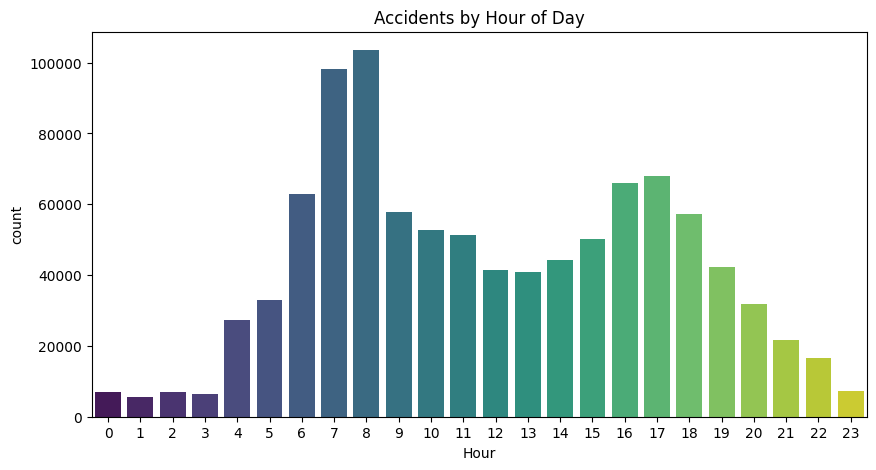

/tmp/ipython-input-3372004326.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="DayOfWeek", data=df, order=[


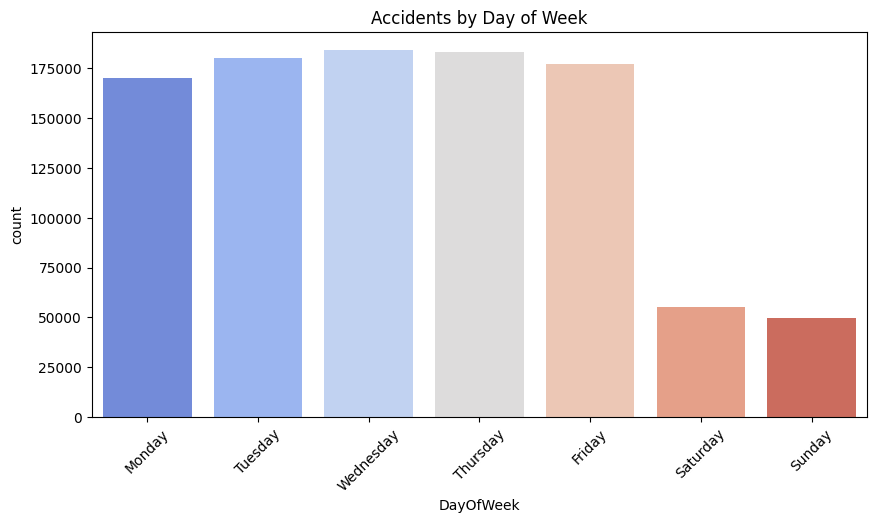

In [6]:
# 📌 Step 2: Time-based Analysis
# ================================
# Convert Start_Time to datetime
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce")

# Extract useful time features
df["Hour"] = df["Start_Time"].dt.hour
df["DayOfWeek"] = df["Start_Time"].dt.day_name()
df["Month"] = df["Start_Time"].dt.month_name()

# Accidents by Hour
plt.figure(figsize=(10,5))
sns.countplot(x="Hour", data=df, palette="viridis")
plt.title("Accidents by Hour of Day")
plt.show()

# Accidents by Day of Week
plt.figure(figsize=(10,5))
sns.countplot(x="DayOfWeek", data=df, order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"], palette="coolwarm")
plt.title("Accidents by Day of Week")
plt.xticks(rotation=45)
plt.show()

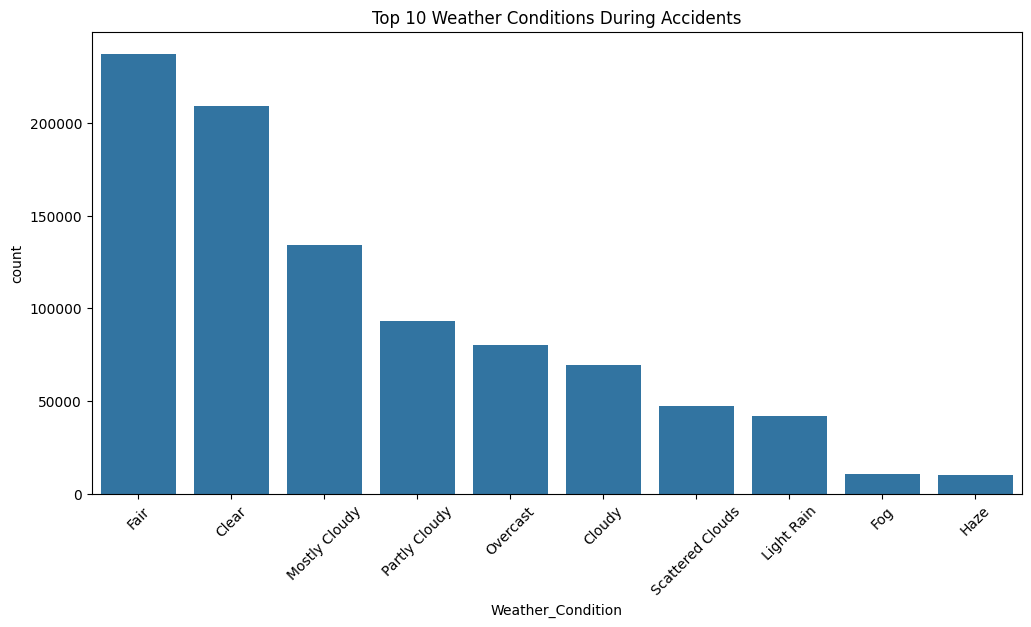

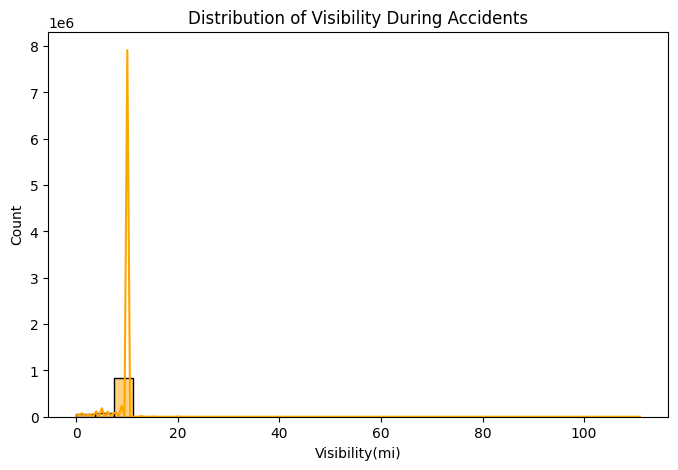

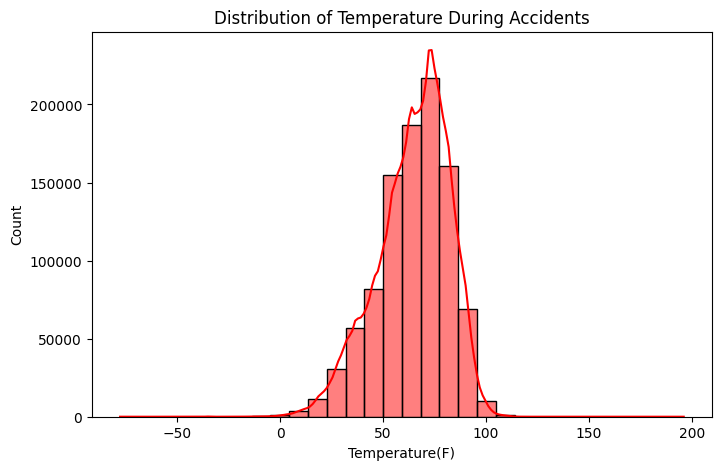

In [7]:
# 📌 Step 3: Weather & Road Impact
# ================================
plt.figure(figsize=(12,6))
sns.countplot(x="Weather_Condition", data=df, order=df["Weather_Condition"].value_counts().head(10).index)
plt.title("Top 10 Weather Conditions During Accidents")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df["Visibility(mi)"].dropna(), bins=30, kde=True, color="orange")
plt.title("Distribution of Visibility During Accidents")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df["Temperature(F)"].dropna(), bins=30, kde=True, color="red")
plt.title("Distribution of Temperature During Accidents")
plt.show()


/tmp/ipython-input-3332798317.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="State", data=df, order=df["State"].value_counts().head(10).index, palette="mako")


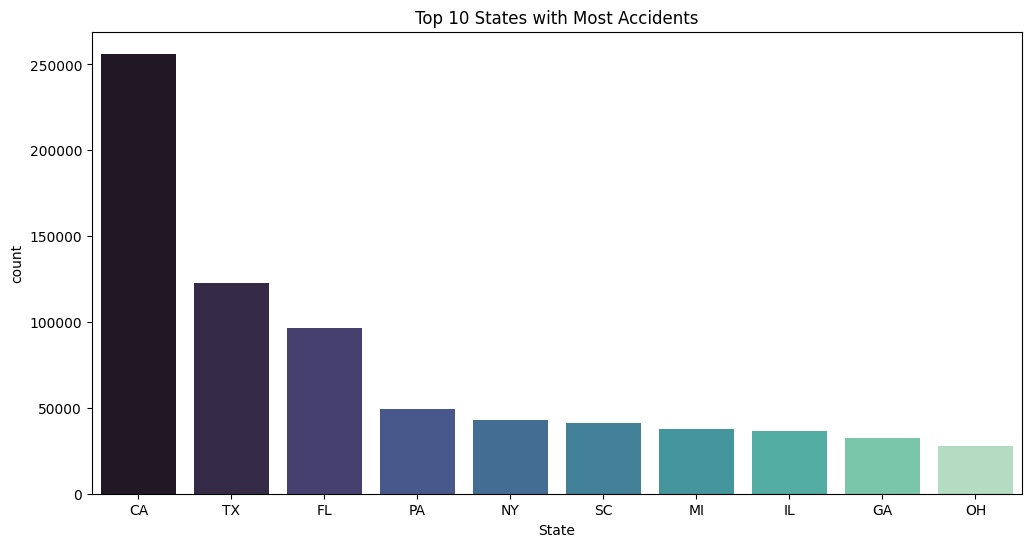

✅ Accident hotspot map saved as accident_hotspots.html


In [8]:
# 📌 Step 4: Geographic Hotspots
# ================================
plt.figure(figsize=(12,6))
sns.countplot(x="State", data=df, order=df["State"].value_counts().head(10).index, palette="mako")
plt.title("Top 10 States with Most Accidents")
plt.show()

# Optional: Interactive Map with Folium (only on small sample to avoid lag)
sample_df = df.sample(5000, random_state=42)

import folium
from folium.plugins import HeatMap

map_center = [sample_df["Start_Lat"].mean(), sample_df["Start_Lng"].mean()]
m = folium.Map(location=map_center, zoom_start=5)

heat_data = list(zip(sample_df["Start_Lat"], sample_df["Start_Lng"]))
HeatMap(heat_data, radius=8).add_to(m)

m.save("accident_hotspots.html")
print("✅ Accident hotspot map saved as accident_hotspots.html")